## <font color='darkblue'>Preface</font>
([course link](https://realpython.com/python-matplotlib-guide/)) <b><font size='3ptx'>A picture is worth a thousand words, and with Python’s [matplotlib](https://matplotlib.org/) library, it fortunately takes far less than a thousand words of code to create a production-quality graphic.</font></b>

However, matplotlib is also a massive library, and getting a plot to look just right is often achieved through trial and error. <b>Using one-liners to generate basic plots in matplotlib is fairly simple, but skillfully commanding the remaining 98% of the library can be daunting</b>.

<b>This article is a beginner-to-intermediate-level walkthrough on matplotlib that mixes theory with examples</b>. While learning by example can be tremendously insightful, it helps to have even just a surface-level understanding of the library’s inner workings and layout as well.

Here’s what we’ll cover:
* Pylab and pyplot: which is which?
* Key concepts of matplotlib’s design
* Understanding `plt.subplots()`
* Visualizing arrays with matplotlib
* Plotting with the pandas + matplotlib combination

<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <b><font size='3ptx'><a href='#sect1'>Why Can Matplotlib Be Confusing?</a></font></b>
* <b><font size='3ptx'><a href='#sect2'>Pylab: What Is It, and Should I Use It?</a></font></b>
* <b><font size='3ptx'><a href='#sect3'>The Matplotlib Object Hierarchy</a></font></b>
* <b><font size='3ptx'><a href='#sect4'>Stateful Versus Stateless Approaches</a></font></b> 
* <b><font size='3ptx'><a href='#sect5'>Understanding `plt.subplots()` Notation</a></font></b>
* <b><font size='3ptx'><a href='#sect6'>The “Figures” Behind The Scenes</a></font></b>
* <b><font size='3ptx'><a href='#sect7'>A Burst of Color: `imshow()` and `matshow()`</a></font></b>
* <b><font size='3ptx'><a href='#sect8'>Plotting in Pandas</a></font></b>
* <b><font size='3ptx'><a href='#sect9'>Wrapping Up</a></font></b>

<a id='sect1'></a>
## <font color='darkblue'>Why Can Matplotlib Be Confusing?</font>
Learning matplotlib can be a frustrating process at times. The problem is not that matplotlib’s documentation is lacking: the documentation is actually extensive. But the following issues can cause some challenges:
* The library itself is huge, at something like 70,000 total lines of code.
* Matplotlib is home to several different interfaces (<font color='brown'>ways of constructing a figure</font>) and capable of interacting with a handful of different backends. (<font color='brown'>Backends deal with the process of how charts are actually rendered, not just structured internally.</font>)
* While it is comprehensive, some of matplotlib’s own public documentation is seriously [out-of-date](https://matplotlib.org/users/shell.html). The library is still evolving, and many older examples floating around online may take 70% fewer lines of code in their modern version.

So, before we get to any glitzy examples, it’s useful to grasp the core concepts of matplotlib’s design.

<a id='sect2'></a>
## <font color='darkblue'>Pylab: What Is It, and Should I Use It?</font> ([back](#sect0))
Let’s start with a bit of history: John D. Hunter, a neurobiologist, began developing matplotlib around 2003, originally inspired to emulate commands from Mathworks’ [MATLAB](https://realpython.com/matlab-vs-python/) software. John passed away tragically young at age 44, in 2012, and matplotlib is now a full-fledged community effort, developed and maintained by a host of others. (<font color='brown'>John gave a [talk](https://www.youtube.com/watch?v=e3lTby5RI54) about the evolution of matplotlib at the 2012 SciPy conference, which is worth a watch.</font>)

One relevant feature of MATLAB is its global style. The Python concept of importing is not heavily used in MATLAB, and most of MATLAB’s [functions](https://www.mathworks.com/help/matlab/functionlist.html) are readily available to the user at the top level.

Knowing that matplotlib has its roots in MATLAB helps to explain why pylab exists. <b>pylab is a module within the matplotlib library that was built to mimic MATLAB’s global style. It exists only to bring a number of functions and classes from both NumPy and matplotlib into the [namespace](https://docs.python.org/3/tutorial/classes.html#python-scopes-and-namespaces), making for an easy transition for former MATLAB users who were not used to needing import statements</b>.

Ex-MATLAB converts (<font color='brown'>who are all fine people, I promise!</font>) liked this functionality, because with `from pylab import *`, they could simply call `plot()` or `array()` directly, as they would in MATLAB.

The issue here may be apparent to some Python users: using `from pylab import *` in a session or script is generally bad practice. Matplotlib now directly advises against this in its own tutorials:
> “[pylab] still exists for historical reasons, but it is highly advised not to use. It pollutes namespaces with functions that will shadow Python built-ins and can lead to hard-to-track bugs. To get IPython integration without imports the use of the %matplotlib magic is preferred.” [Source](https://matplotlib.org/users/shell.html#using-matplotlib-in-a-python-shell)

<br/>

<b>The bottom line is that matplotlib has abandoned this convenience module and now explicitly recommends against using pylab, bringing things more in line with one of Python’s key notions: explicit is better than implicit</b>.

Without the need for pylab, we can usually get away with just one canonical import:

In [1]:
import matplotlib.pyplot as plt

While we’re at it, let’s also import NumPy, which we’ll use for generating data later on, and call <font color='blue'>np.random.seed()</font> to make examples with (<font color='brown'>pseudo</font>) random data reproducible:

In [2]:
import numpy as np

np.random.seed(444)

<a id='sect3'></a>
## <font color='darkblue'>The Matplotlib Object Hierarchy</font> ([back](#sect0))
<b><font size='3ptx'>One important big-picture matplotlib concept is its object hierarchy.</font></b>

If you’ve worked through any introductory matplotlib tutorial, you’ve probably called something like `plt.plot([1, 2, 3])`. This one-liner hides the fact that <b>a plot is really a hierarchy of nested Python objects. A “hierarchy” here means that there is a tree-like structure of matplotlib objects underlying each plot</b>.

<b>A <font color='darkblue'>Figure</font> object is the outermost container for a matplotlib graphic, which can contain multiple Axes objects</b>. One source of confusion is the name: an Axes actually translates into what we think of as an individual plot or graph (<font color='brown'>rather than the plural of “axis,” as we might expect</font>).

<b>You can think of the <font color='darkblue'>Figure</font> object as a box-like container holding one or more Axes</b> (<font color='brown'>actual plots</font>). Below the Axes in the hierarchy are smaller objects such as tick marks, individual lines, legends, and text boxes. Almost every “element” of a chart is its own manipulable Python object, all the way down to the ticks and labels:
![Figure vs Axes](images/1.PNG)


Here’s an illustration of this hierarchy in action. Don’t worry if you’re not completely familiar with this notation, which we’ll cover later on:

In [3]:
%matplotlib agg
plt.rcParams['figure.figsize'] = [3, 3]
fig, _ = plt.subplots()

In [4]:
type(fig)

matplotlib.figure.Figure

Above, we created two variables with <font color='blue'>plt.subplots()</font>. The first is a top-level [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object. The second is a “throwaway” variable that we don’t need just yet, denoted with an underscore. Using attribute notation, it is easy to traverse down the figure hierarchy and see the first tick of the y axis of the first [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object:

In [5]:
one_tick = fig.axes[0].yaxis.get_major_ticks()[0]
type(one_tick)

matplotlib.axis.YTick

Above, `fig` (<font color='brown'>a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) class instance</font>) has multiple [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) (<font color='brown'>a list, for which we take the first element</font>). Each[**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) has a yaxis and xaxis, each of which have a collection of “major ticks,” and we grab the first one.

Matplotlib presents this as a figure anatomy, rather than an explicit hierarchy:
![Figure hierarchy](images/2.PNG)

<a id='sect4'></a>
## <font color='darkblue'>Stateful Versus Stateless Approaches</font> ([back](#sect0))
<b><font size='3ptx'>Alright, we need one more chunk of theory before we can get around to the shiny visualizations: the difference between the stateful (<font color='brown'>state-based, state-machine</font>) and stateless ([object-oriented](https://realpython.com/python3-object-oriented-programming/), OO) interfaces.</font></b>

Above, we used `import matplotlib.pyplot as plt` to import the pyplot module from matplotlib and name it `plt`.

Almost all functions from pyplot, such as `plt.plot()`, are implicitly either referring to an existing current [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes), or creating them anew if none exist. Hidden in the matplotlib docs is this helpful snippet:
> “`[With pyplot]`, simple functions are used to add plot elements (lines, images, text, etc.) <b>to the current axes in the current figure</b>.” `[emphasis added]`

<br/>

Hardcore ex-MATLAB users may choose to word this by saying something like, “`plt.plot()` is a state-machine interface that implicitly tracks the current figure!” In English, this means that:
* The stateful interface makes its calls with `plt.plot()` and other top-level pyplot functions. There is only ever one [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) or [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) that you’re manipulating at a given time, and you don’t need to explicitly refer to it.
* Modifying the underlying objects directly is the object-oriented approach. We usually do this by calling methods of an [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object, which is the object that represents a plot itself.

<br/>

The flow of this process, at a high level, looks like this:
![Figure hierarchy](images/3.PNG)

Tying these together, most of the functions from pyplot also exist as methods of the [**matplotlib.axes.Axes class**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes). This is easier to see by peeking under the hood. <font color='blue'>plt.plot()</font> can be boiled down to five or so lines of code:
```python
# matplotlib/pyplot.py
>>> def plot(*args, **kwargs):
...     """An abridged version of plt.plot()."""
...     ax = plt.gca()
...     return ax.plot(*args, **kwargs)

>>> def gca(**kwargs):
...     """Get the current Axes of the current Figure."""
...     return plt.gcf().gca(**kwargs)
```

<br/>

Calling `plt.plot()` is just a convenient way to get the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) of the current [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and then call its <font color='blue'>plot()</font> method. This is what is meant by the assertion that the stateful interface always “implicitly tracks” the plot that it wants to reference.

pyplot is home to a [batch of functions](https://matplotlib.org/api/pyplot_summary.html#the-pyplot-api) that are really just wrappers around matplotlib’s object-oriented interface. For example, with <font color='blue'>plt.title()</font>, there are corresponding setter and getter methods within the OO approach, <font color='blue'>ax.set_title()</font> and <font color='blue'>ax.get_title()</font>. (<font color='brown'>Use of getters and setters tends to be more popular in languages such as Java but is a key feature of matplotlib’s OO approach.</font>)

Calling <font color='blue'>plt.title()</font> gets translated into this one line: <font color='blue'>gca().set_title(s, *args, **kwargs)</font>. Here’s what that is doing:
* <font color='blue'>gca()</font> grabs the current axis and returns it.
* <font color='blue'>set_title()</font> is a setter method that sets the title for that [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object. The “convenience” here is that we didn’t need to specify any [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) object explicitly with <font color='blue'>plt.title()</font>.


Similarly, if you take a few moments to look at the source for top-level functions like [plt.grid()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L3708), [plt.legend()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L3714), and [plt.ylabels()](https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/pyplot.py#L1521), you’ll notice that all of them follow the same structure of delegating to the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) with <font color='blue'>gca()</font> and then calling some method of the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes). (<font color='brown'>This is the underlying object-oriented approach!</font>)

<a id='sect5'></a>
## <font color='darkblue'>Understanding `plt.subplots()` Notation</font> ([back](#sect0))
<b><font size='3ptx'>Alright, enough theory. Now, we’re ready to tie everything together and do some plotting.</font></b>

<b>From here on out, we’ll mostly rely on the stateless</b> (<font color='brown'>object-oriented</font>) <b>approach</b>, which is more customizable and comes in handy as graphs become more complex. The prescribed way to create a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) with a single [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) under the OO approach is (<font color='brown'>not too intuitively</font>) with <font color='blue'>plt.subplots()</font>. This is really the only time that the OO approach uses pyplot, to create a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes):

In [6]:
fig, ax = plt.subplots()

Above, we took advantage of iterable unpacking to assign a separate variable to each of the two results of [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots). Notice that we didn’t pass arguments to [subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots) here. The default call is <font color='blue'>subplots(nrows=1, ncols=1)</font>. Consequently, `ax` is a single <b><font color='blue'>AxesSubplot</font></b> object:

In [7]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

We can call its instance methods to manipulate the plot similarly to how we call pyplots functions. Let’s illustrate with a stacked area graph of three time series:

In [8]:
rng = np.arange(50)
rnd = np.random.randint(0, 10, size=(3, rng.size))
yrs = 1950 + rng

In [9]:
rnd

array([[3, 0, 7, 8, 3, 4, 7, 6, 8, 9, 2, 2, 2, 0, 3, 8, 0, 6, 6, 0, 3, 0,
        6, 7, 9, 3, 8, 7, 3, 2, 6, 9, 2, 9, 8, 9, 3, 2, 2, 8, 1, 5, 6, 7,
        6, 0, 0, 0, 0, 4],
       [8, 1, 9, 8, 5, 8, 9, 4, 6, 6, 4, 1, 8, 2, 7, 9, 3, 4, 2, 5, 0, 0,
        8, 1, 0, 9, 9, 3, 2, 7, 6, 0, 5, 5, 4, 8, 3, 4, 9, 4, 7, 1, 5, 4,
        4, 0, 2, 2, 5, 8],
       [5, 6, 6, 1, 1, 6, 8, 4, 1, 0, 9, 2, 3, 7, 3, 3, 2, 7, 8, 6, 6, 7,
        5, 7, 3, 9, 1, 3, 0, 4, 7, 5, 1, 5, 1, 4, 9, 7, 2, 4, 3, 7, 9, 2,
        2, 0, 1, 5, 2, 4]])

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.set_title('Combined debt growth over time')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
fig.tight_layout()

Here’s what’s going on above:
* After creating three random time series, we defined one [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) (`fig`) containing one [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) (a plot, `ax`).
* We call methods of `ax` directly to create a stacked area chart and to add a legend, title, and y-axis label. Under the object-oriented approach, it’s clear that all of these are attributes of `ax`.
* <font color='blue'>tight_layout()</font> applies to the [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object as a whole to clean up whitespace padding.


Let’s look at an example with multiple subplots (Axes) within one Figure, plotting two correlated arrays that are drawn from the discrete uniform distribution:

In [11]:
x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
y

array([11,  5,  6,  7, 14, 13,  8, 10, 11,  8, 10,  7,  6, 11,  6, 10,  8,
       13,  6, 11, 10,  6,  6,  9,  9, 13,  8, 12, 12, 11,  9,  4,  6,  5,
        4,  2,  9,  8,  7,  8,  6,  3, 13,  8, 12,  4,  9,  7,  4, 11])

In [12]:
x

array([ 9,  1,  5,  6, 10,  9,  7,  7, 10,  6,  8,  6,  4,  9,  3,  7,  6,
        9,  2, 10,  7,  2,  2,  5,  7,  9,  5,  9,  9,  8,  6,  3,  4,  3,
        1,  1,  5,  7,  6,  4,  4,  1,  9,  5, 10,  3,  5,  4,  1,  9])

In [13]:
data = np.column_stack((x, y))
data[:10]

array([[ 9, 11],
       [ 1,  5],
       [ 5,  6],
       [ 6,  7],
       [10, 14],
       [ 9, 13],
       [ 7,  8],
       [ 7, 10],
       [10, 11],
       [ 6,  8]])

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.hist(data, bins=np.arange(data.min(), data.max()), label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()

There’s a little bit more going on in this example:
* Because we’re creating a “1x2” Figure, the returned result of <font color='blue'>plt.subplots(1, 2)</font> is now a [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object and a NumPy array of [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects. (<font color='brown'>You can inspect this with `fig, axs = plt.subplots(1, 2)` and taking a look at axs.</font>)
* We deal with `ax1` and `ax2` individually, which would be difficult to do with the stateful approach. The final line is a good illustration of the object hierarchy, where we are modifying the yaxis belonging to the second Axes, placing its ticks and ticklabels to the right.
* Text inside dollar signs utilizes [TeX markup](https://en.wikipedia.org/wiki/TeX) to put variables in italics.

<br/>

Remember that multiple [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) can be enclosed in or “belong to” a given figure. In the case above, fig.axes gets us a list of all the [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects:

In [15]:
(fig.axes[0] is ax1, fig.axes[1] is ax2)

(True, True)

Taking this one step further, we could alternatively create a figure that holds a 2x2 grid of [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) objects:

In [16]:
%matplotlib agg
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
type(ax)

numpy.ndarray

Now, what is ax? It’s no longer a single Axes, but a two-dimensional NumPy array of them:

In [17]:
ax

array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

In [18]:
ax.shape

(2, 2)

This is reaffirmed by the docstring:
> “ax can be either a single [**matplotlib.axes.Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) object or an array of [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) objects if more than one subplot was created.”

<br/>

We now need to call plotting methods on each of these [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) (<font color='brown'>but not the NumPy array, which is just a container in this case</font>). A common way to address this is to use iterable unpacking after flattening the array to be one-dimensional:
```python
>>> fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
>>> ax1, ax2, ax3, ax4 = ax.flatten()  # flatten a 2d NumPy array to 1d
```

<br/>

To illustrate some more advanced subplot features, let’s pull some macroeconomic California housing data extracted from a compressed tar archive, using [**io**](https://docs.python.org/3/library/io.html), [**tarfile**](https://docs.python.org/3/library/tarfile.html), and [**urllib**](https://docs.python.org/3/library/urllib.html) from Python’s Standard Library.

In [19]:
%%time
from io import BytesIO
import tarfile
from urllib.request import urlopen

url = 'http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz'
b = BytesIO(urlopen(url).read())
fpath = 'CaliforniaHousing/cal_housing.data'

with tarfile.open(mode='r', fileobj=b) as archive:
  housing = np.loadtxt(archive.extractfile(fpath), delimiter=',')

CPU times: user 96.3 ms, sys: 4.13 ms, total: 100 ms
Wall time: 3.22 s


The “response” variable `y` below, to use the statistical term, is an area’s average home value. `pop` and `age` are the area’s population and average house age, respectively:

In [20]:
y = housing[:, -1]
pop, age = housing[:, [4, 7]].T

In [21]:
# Top 3 area's population
pop[:3]

array([ 129., 1106.,  190.])

Next let’s define a “helper function” that places a text box inside of a plot and acts as an “in-plot title”:

In [22]:
def add_titlebox(ax, text):
  ax.text(.55, .8, text,
      horizontalalignment='center',
      transform=ax.transAxes,
      bbox=dict(facecolor='white', alpha=0.6),
      fontsize=12.5)
  return ax

We’re ready to do some plotting. Matplotlib’s [**gridspec**](https://matplotlib.org/stable/api/gridspec_api.html) module allows for more subplot customization. pyplot’s <font color='blue'>subplot2grid()</font> interacts with this module nicely. Let’s say we want to create a layout like this:
![4](images/4.PNG)

Above, what we actually have is a 3x2 grid. ax1 is twice the height and width of ax2/ax3, meaning that it takes up two columns and two rows:
![5](images/5.PNG)

The second argument to <font color='blue'>subplot2grid()</font> is the `(row, column)` location of the [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) within the grid:
```python
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
```

Now, we can proceed as normal, modifying each [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) individually:

In [23]:
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))

ax1.set_title('Home value as a function of home age & area population', fontsize=14)
sctr = ax1.scatter(x=age, y=pop, c=y, cmap='RdYlGn')
plt.colorbar(sctr, ax=ax1, format='$%d')
ax1.set_yscale('log')

ax2.hist(age, bins='auto')
add_titlebox(ax2, 'Histogram: home age')

ax3.hist(pop, bins='auto', log=True)
add_titlebox(ax3, 'Histogram: area population (log scl.)')
plt.show()

Above, <font color='blue'>colorbar()</font> (<font color='brown'>different from ColorMap earlier</font>) gets called on the [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) directly, rather than the [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html). Its first argument uses Matplotlib’s <font color='brown'>.scatter()</font> and is the result of <font color='blue'>ax1.scatter()</font>, which functions as a mapping of y-values to a ColorMap.

Visually, there isn’t much differentiation in color (the y-variable) as we move up and down the y-axis, indicating that home age seems to be a stronger determinant of house value.

<a id='sect6'></a>
## <font color='darkblue'>The “Figures” Behind The Scenes</font> ([back](#sect0))
Each time you call <font color='blue'>plt.subplots()</font> or the less frequently used <font color='blue'>plt.figure()</font> (<font color='brown'>which creates a Figure, with no [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html)</font>), you are creating a new [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object that matplotlib sneakily keeps around in memory. Earlier, we alluded to the concept of a current [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html)</font>).

By default, these are the most recently created [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html), which we can show with the built-in function [id()](https://docs.python.org/3/library/functions.html#id) to display the address of the object in memory:

In [24]:
%matplotlib agg
fig1, ax1 = plt.subplots()

In [25]:
id(fig1)

140701038932224

In [26]:
id(plt.gcf())  # `fig1` is the current figure.

140701038932224

In [27]:
%matplotlib agg
fig2, ax2 = plt.subplots()
id(fig2) == id(plt.gcf())  # The current figure has changed to `fig2`.

True

After the above routine, the current figure is `fig2`, the most recently created figure. However, both figures are still hanging around in memory, each with a corresponding ID number (1-indexed, in MATLAB style):

In [28]:
%matplotlib agg
fig1 = plt.figure()
fig2 = plt.figure()
plt.get_fignums()

[1, 2]

A useful way to get all of the Figures themselves is with a mapping of plt.figure() to each of these integers:

In [29]:
%matplotlib agg
fig1 = plt.figure()
fig2 = plt.figure()

def get_all_figures():
    return [plt.figure(i) for i in plt.get_fignums()]

get_all_figures()

[<Figure size 300x300 with 0 Axes>, <Figure size 300x300 with 0 Axes>]

<b>Be cognizant of this if running a script where you’re creating a group of figures. You’ll want to explicitly close each of them after use to avoid a MemoryError</b>. By itself, <font color='blue'>plt.close()</font> closes the current figure, <font color='blue'>plt.close(num)</font> closes the figure number num, and <font color='blue'>plt.close('all')</font> closes all the figure windows:

In [30]:
plt.close('all')

<a id='sect7'></a>
## <font color='darkblue'>A Burst of Color: `imshow()` and `matshow()`</font> ([back](#sect0))
<b><font size='3ptx'>While <font color='blue'>ax.plot()</font> is one of the most common plotting methods on an [Axes](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html), there are a whole host of others, as well. (<font color='brown'>We used</font> <font color='blue'>ax.stackplot()</font> <font color='brown'>above. You can find the complete list</font> [here](https://matplotlib.org/api/axes_api.html?highlight=axes%20class#plotting).)</font></b>

Methods that get heavy use are [imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [matshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html), with the latter being a wrapper around the former. These are useful anytime that a raw numerical array can be visualized as a colored grid.

First, let’s create two distinct grids with some fancy NumPy indexing:

In [31]:
x = np.diag(np.arange(2, 12))[::-1]
x[np.diag_indices_from(x[::-1])] = np.arange(2, 12)
x2 = np.arange(x.size).reshape(x.shape)

In [32]:
x

array([[ 2,  0,  0,  0,  0,  0,  0,  0,  0, 11],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  9,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  0, 11]])

Next, we can map these to their image representations. In this specific case, we toggle “off” all axis labels and ticks by using a dictionary comprehension and passing the result to <font color='blue'>ax.tick_params()</font>:

In [33]:
sides = ('left', 'right', 'top', 'bottom')
nolabels = {s: False for s in sides}
nolabels.update({'label%s' % s: False for s in sides})
print(nolabels)

{'left': False, 'right': False, 'top': False, 'bottom': False, 'labelleft': False, 'labelright': False, 'labeltop': False, 'labelbottom': False}


Then, we can use a [context manager](https://docs.python.org/3/reference/datamodel.html#context-managers) to disable the grid, and call [matshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html) on each [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html). Lastly, we need to put the colorbar in what is technically a new [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) within fig. For this, we can use a bit of an esoteric function from deep within matplotlib:

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

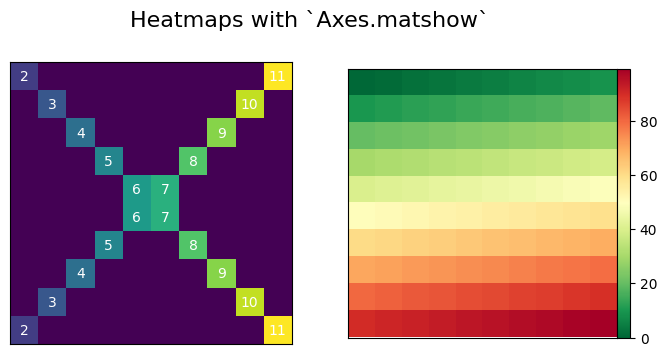

In [35]:
%matplotlib inline
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

with plt.rc_context(rc={'axes.grid': False}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.matshow(x)
    img2 = ax2.matshow(x2, cmap='RdYlGn_r')
    for ax in (ax1, ax2):
        ax.tick_params(axis='both', which='both', **nolabels)
        
    for i, j in zip(*x.nonzero()):
        ax1.text(j, i, x[i, j], color='white', ha='center', va='center')
        
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size='5%', pad=0)
    plt.colorbar(img2, cax=cax, ax=[ax1, ax2])
    fig.suptitle('Heatmaps with `Axes.matshow`', fontsize=16)
    plt.show()

<a id='sect8'></a>
## <font color='darkblue'>Plotting in Pandas</font> ([back](#sect0))
<b><font size='3ptx'>The pandas library has become popular for not just for enabling powerful [data analysis](https://realpython.com/analyzing-obesity-in-england-with-python/), but also for its handy pre-canned plotting methods. Interestingly though, [pandas plotting methods](https://realpython.com/pandas-plot-python/) are really just convenient wrappers around existing matplotlib calls.</font></b>

That is, the <font color='blue'>plot()</font> method on pandas’ [**Series**](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) and [**DataFrame**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) is a wrapper around <font color='blue'>plt.plot()</font>.

One convenience provided, for example, is that if the DataFrame’s Index consists of dates, <font color='blue'>gcf().autofmt_xdate()</font> is called internally by pandas to get the current Figure and nicely auto-format the x-axis.

In turn, remember that <font color='blue'>plt.plot()</font> (<font color='brown'>the state-based approach</font>) is implicitly aware of the current Figure and current Axes, so pandas is following the state-based approach by extension.

We can prove this “chain” of function calls with a bit of introspection. First, let’s construct a plain-vanilla pandas Series, assuming we’re starting out in a fresh interpreter session:

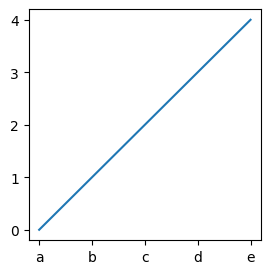

In [39]:
import pandas as pd

s = pd.Series(np.arange(5), index=list('abcde'))
ax = s.plot()

In [41]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

This internal architecture is helpful to know when you are mixing pandas plotting methods with traditional matplotlib calls, which is done below in plotting the moving average of a widely watched financial time series. `ma` is a pandas Series for which we can call `ma.plot()` (<font color='brown'>the pandas method</font>), and then customize by retrieving the [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) that is created by this call (<font color='blue'>plt.gca()</font>), for matplotlib to reference:

In [44]:
import pandas as pd
import matplotlib.transforms as mtransforms

url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=VIXCLS'
vix = pd.read_csv(url, index_col=0, parse_dates=True, na_values='.',
                  infer_datetime_format=True).squeeze("columns").dropna()
                 
ma = vix.rolling('90d').mean()

In [46]:
ma[:5]

DATE
1990-01-02    17.240000
1990-01-03    17.715000
1990-01-04    18.216667
1990-01-05    18.690000
1990-01-08    19.004000
Name: VIXCLS, dtype: float64

In [47]:
state = pd.cut(ma, bins=[-np.inf, 14, 18, 24, np.inf], labels=range(4))

In [56]:
state[:5]

DATE
1990-01-02    1
1990-01-03    1
1990-01-04    2
1990-01-05    2
1990-01-08    2
Name: VIXCLS, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

<AxesSubplot: xlabel='DATE'>

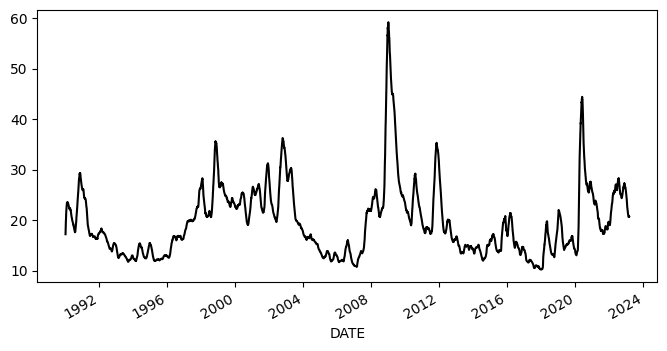

In [48]:
cmap = plt.get_cmap('RdYlGn_r')
ma.plot(color='black', linewidth=1.5, marker='', figsize=(8, 4),
        label='VIX 90d MA')

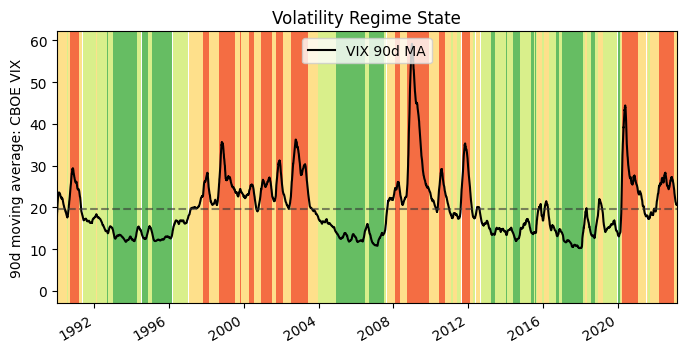

In [54]:
ma.plot(color='black', linewidth=1.5, marker='', figsize=(8, 4),
        label='VIX 90d MA')
ax = plt.gca()  # Get the current Axes that ma.plot() references
ax.set_xlabel('')
ax.set_ylabel('90d moving average: CBOE VIX')
ax.set_title('Volatility Regime State')
ax.grid(False)
ax.legend(loc='upper center')
ax.set_xlim(xmin=ma.index[0], xmax=ma.index[-1])
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
for i, color in enumerate(cmap([0.2, 0.4, 0.6, 0.8])):
    ax.fill_between(ma.index, 0, 1, where=state==i,
                    facecolor=color, transform=trans)
ax.axhline(vix.mean(), linestyle='dashed', color='xkcd:dark grey',
           alpha=0.6, label='Full-period mean', marker='')
fig.show()

There’s a lot happening above:
* `ma` is a 90-day moving average of the VIX Index, a measure of market expectations of near-term stock volatility. `state` is a binning of the moving average into different regime states. A high VIX is seen as signaling a heightened level of fear in the marketplace.
* `cmap` is a ColorMap—a matplotlib object that is essentially a mapping of floats to RGBA colors. Any colormap can be reversed by appending '_r', so 'RdYlGn_r' is the reversed Red-Yellow-Green colormap. Matplotlib maintains a handy [visual reference guide](https://matplotlib.org/examples/color/colormaps_reference.html) to ColorMaps in its docs.
* The only real pandas call we’re making here is <font color='blue'>ma.plot()</font>. This calls <font color='blue'>plt.plot()</font> internally, so to integrate the object-oriented approach, we need to get an explicit reference to the current [**Axes**](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) with `ax = plt.gca()`.
* The second chunk of code creates color-filled blocks that correspond to each bin of state. `cmap([0.2, 0.4, 0.6, 0.8])` says, “Get us an RGBA sequence for the colors at the 20th, 40th, 60th, and 80th ‘percentile’ along the ColorMaps’ spectrum.” `enumerate()` is used because we want to map each RGBA color back to a state.

<br/>

Pandas also comes built-out with a smattering of more advanced plots (which could take up an entire tutorial all on their own). However, all of these, like their simpler counterparts, rely on matplotlib machinery internally.

<a id='sect9'></a>
## <font color='darkblue'>Wrapping Up</font> ([back](#sect0))
As shown by some of the examples above, there’s no getting around the fact that matplotlib can be a technical, syntax-heavy library. Creating a production-ready chart sometimes requires a half hour of Googling and combining a hodgepodge of lines in order to fine-tune a plot.

However, understanding how matplotlib’s interfaces interact is an investment that can pay off down the road. As Real Python’s own Dan Bader has advised, <b>taking the time to dissect code rather than resorting to the Stack Overflow “copy pasta” solution tends to be a smarter long-term solution. Sticking to the object-oriented approach can save hours of frustration when you want to take a plot from plain to a work of art</b>.

## <font color='darkblue'>Appendix A: Configuration and Styling</font> ([back](#sect0))
If you’ve been following along with this tutorial, it’s likely that the plots popping up on your screen look different stylistically than the ones shown here. Matplotlib offers two ways to configure style in a uniform way across different plots:
1. By customizing a [matplotlibrc](https://matplotlib.org/users/customizing.html) file
2. By changing your configuration parameters interactively, or from a .py script.

A `matplotlibrc` file (<font color='brown'>Option \#1 above</font>) is basically a text file specifying user-customized settings that are remembered between Python sessions. On Mac OS X, this normally resides at <font color='olive'>~/.matplotlib/matplotlibrc</font>.

<b><font color='darkred'>Quick Tip:</font></b>
> GitHub is a great place to keep configuration files. I keep mine here. Just make sure that they don’t contain personally identifiable or private information, such as passwords or SSH private keys!

Alternatively, you can change your configuration parameters interactively (<font color='brown'>Option \#2 above</font>). When you `import matplotlib.pyplot as plt`, you get access to an `rcParams` object that resembles a Python dictionary of settings. All of the module objects starting with “rc” are a means to interact with your plot styles and settings:

In [57]:
[attr for attr in dir(plt) if attr.startswith('rc')]

['rc',
 'rcParams',
 'rcParamsDefault',
 'rcParamsOrig',
 'rc_context',
 'rcdefaults',
 'rcsetup']

Of these:
* `plt.rcdefaults()` restores the rc parameters from matplotlib’s internal defaults, which are listed at `plt.rcParamsDefault`. This will revert (<font color='brown'>overwrite</font>) whatever you’ve already customized in a <font color='olive'>matplotlibrc</font> file.
* `plt.rc()` is used for setting parameters interactively.
* `plt.rcParams` is a (<font color='brown'>mutable</font>) dictionary-like object that lets you manipulate settings directly. If you have customized settings in a <font color='olive'>matplotlibrc</font> file, these will be reflected in this dictionary.

<br/>

With `plt.rc()` and `plt.rcParams`, these two syntaxes are equivalent for adjusting settings:
```python
>>> plt.rc('lines', linewidth=2, color='r')  # Syntax 1

>>> plt.rcParams['lines.linewidth'] = 2  # Syntax 2
>>> plt.rcParams['lines.color'] = 'r'
```

<br/>

Notably, the [**Figure**](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) class then uses some of these as its default arguments.

Relatedly, a style is just a predefined cluster of custom settings. To view available styles, use:

In [58]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

To set a style, make this call:

In [59]:
plt.style.use('fivethirtyeight')

Your plots will now take on a new look:

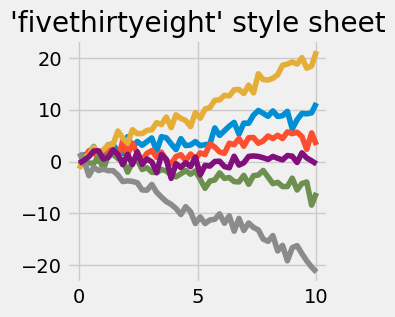

In [60]:
x = np.linspace(0, 10)

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, ax = plt.subplots()

ax.plot(x, np.sin(x) + x + np.random.randn(50))
ax.plot(x, np.sin(x) + 0.5 * x + np.random.randn(50))
ax.plot(x, np.sin(x) + 2 * x + np.random.randn(50))
ax.plot(x, np.sin(x) - 0.5 * x + np.random.randn(50))
ax.plot(x, np.sin(x) - 2 * x + np.random.randn(50))
ax.plot(x, np.sin(x) + np.random.randn(50))
ax.set_title("'fivethirtyeight' style sheet")

plt.show()

This full example is available [here](https://matplotlib.org/examples/style_sheets/plot_fivethirtyeight.html). For inspiration, matplotlib keeps some [style sheet displays](https://matplotlib.org/gallery.html#style_sheets) for reference as well.

## <font color='darkblue'>Appendix B: Interactive Mode</font> ([back](#sect0))
Behind the scenes, matplotlib also interacts with different backends. A backend is the workhorse behind actually rendering a chart. (<font color='brown'>On the popular Anaconda distribution, for instance, the default backend is Qt5Agg.</font>) Some backends are interactive, meaning they are dynamically updated and “pop up” to the user when changed.

While interactive mode is off by default, you can check its status with `plt.rcParams['interactive']` or `plt.isinteractive()`, and toggle it on and off with `plt.ion()` and `plt.ioff()`, respectively:

In [61]:
plt.rcParams['interactive']

True

In [62]:
plt.ioff()
plt.rcParams['interactive']

False

In some code examples, you may notice the presence of `plt.show()` at the end of a chunk of code. The main purpose of `plt.show()`, as the name implies, is to actually “show” (<font color='brown'>open</font>) the figure <b>when you’re running with interactive mode turned off. In other words</b>:
* If interactive mode is on, you don’t need `plt.show()`, and images will automatically pop-up and be updated as you reference them.
* If interactive mode is off, you’ll need `plt.show()` to display a figure and `plt.draw()` to update a plot.

<b>Notably, interactive mode has nothing to do with what IDE you’re using</b>, or whether you’ve enable inline plotting with something like jupyter notebook `--matplotlib inline` or `%matplotlib`.

## <font color='darkblue'>Supplement</font>
* [Stackoverflow - prevent plot from showing in jupyter notebook](https://stackoverflow.com/questions/18717877/prevent-plot-from-showing-in-jupyter-notebook)